In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import kagglehub

# Importing Deep Learning Libraries
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [ ]:
# Download FER-2013 dataset
print("Downloading FER-2013...")
path = kagglehub.dataset_download("msambare/fer2013")
print(f"Path to dataset: {path}")

picture_size = 48
folder_path = path + "/"

Using Colab cache for faster access to the 'fer2013' dataset.
Path to dataset: /kaggle/input/fer2013


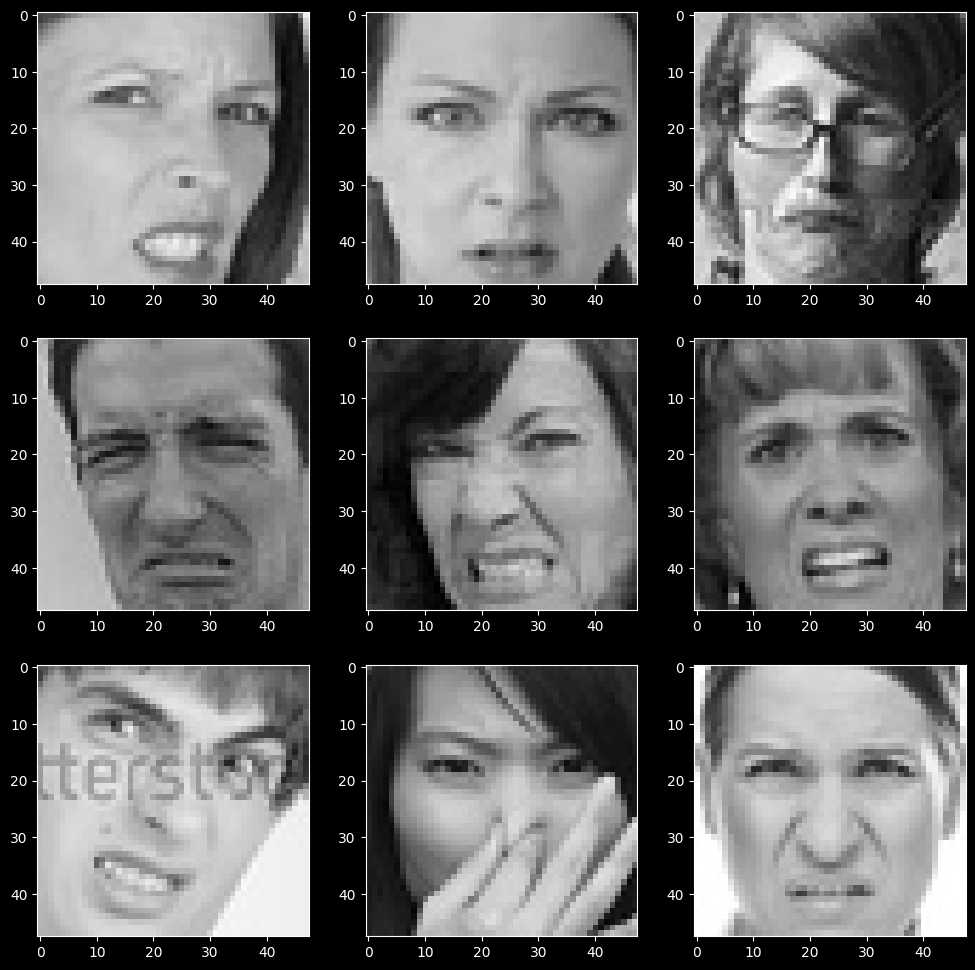

In [ ]:
expression = 'disgust'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)
plt.show()

In [ ]:

batch_size = 64
picture_size = 48
seed = 42

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

# Training data generator with augmentation + rescaling
datagen_train = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation / Test generator
datagen_val = ImageDataGenerator(rescale=1.0/255.0)

# Load Training Data
train_set = datagen_train.flow_from_directory(
    folder_path + "train",
    target_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=seed
)

# Load Test / Validation Data
test_set = datagen_val.flow_from_directory(
    folder_path + "test",
    target_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,   # important for evaluation / matching y_true order
    seed=seed
)

print(f"Found {train_set.n} training images belonging to {len(train_set.class_indices)} classes.")
print(f"Found {test_set.n} test images belonging to {len(test_set.class_indices)} classes.")

# steps per epoch helpers
steps_per_epoch = math.ceil(train_set.n / batch_size)
validation_steps = math.ceil(test_set.n / batch_size)
print("steps_per_epoch:", steps_per_epoch, "validation_steps:", validation_steps)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 28709 training images belonging to 7 classes.
Found 7178 test images belonging to 7 classes.
steps_per_epoch: 449 validation_steps: 113


In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

no_of_classes = 7

model = Sequential()

# Conv block 1
model.add(Conv2D(32, (3,3), padding='same', input_shape=(48,48,1),
                 kernel_regularizer=regularizers.l2(1e-4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

# Conv block 2
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

# Conv block 3
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

# Conv block 4 (enabled)
model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.4))

# Global pooling + head
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.45))
model.add(Dense(no_of_classes, activation='softmax'))

opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 424,071 (1.62 MB)

 Trainable params: 422,855 (1.61 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [ ]:
import math
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# --- hyperparams
batch_size = train_set.batch_size if hasattr(train_set, "batch_size") else 64
epochs = 30
initial_lr = 1e-4

# --- callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-7)

callbacks_list = [early_stopping, checkpoint, reduce_lr]

# --- compile
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=initial_lr)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# --- compute steps
steps_per_epoch = math.ceil(train_set.n / batch_size)
validation_steps = math.ceil(test_set.n / batch_size)
print("steps_per_epoch:", steps_per_epoch, "validation_steps:", validation_steps)




steps_per_epoch: 449 validation_steps: 113


In [ ]:
history = model.fit(
    train_set,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_set,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
 77/449 ━━━━━━━━━━━━━━━━━━━━ 4:13 680ms/step - accuracy: 0.4161 - loss: 1.5455

KeyboardInterrupt: 

In [ ]:

import os
print("cwd:", os.getcwd())
for f in os.listdir():
    print(f)

if os.path.exists("best_model.keras"):
    print("Found .best_model.keras")
else:
    print("No model.h5 found in current directory. Check checkpoint name or path.")


cwd: /content
.config
best_model.keras
sample_data
Found .best_model.keras


In [ ]:

from tensorflow.keras.models import load_model

checkpoint_path = "best_model.keras"
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"{checkpoint_path} not found. Change the path to your saved model.")
model = load_model(checkpoint_path)
print("Model loaded. Summary:")
model.summary()

Model loaded. Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,269,783 (4.84 MB)

 Trainable params: 422,855 (1.61 MB)

 Non-trainable params: 1,216 (4.75 KB)

 Optimizer params: 845,712 (3.23 MB)

NameError: name 'history' is not defined

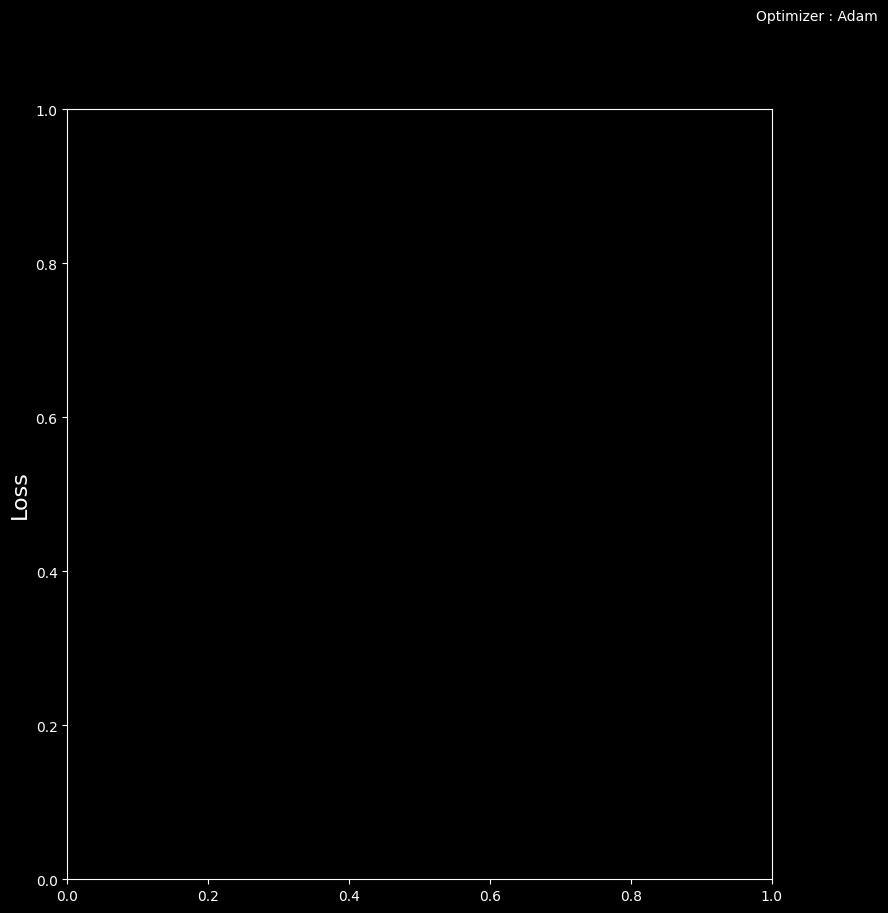

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


y_true = test_set.classes
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)


print(classification_report(y_true, y_pred, target_names=test_set.class_indices.keys()))


113/113 ━━━━━━━━━━━━━━━━━━━━ 46s 410ms/step
              precision    recall  f1-score   support

       angry       0.39      0.16      0.23       958
     disgust       0.00      0.00      0.00       111
        fear       0.25      0.11      0.15      1024
       happy       0.59      0.76      0.66      1774
     neutral       0.40      0.51      0.45      1233
         sad       0.39      0.37      0.38      1247
    surprise       0.51      0.76      0.61       831

    accuracy                           0.47      7178
   macro avg       0.36      0.38      0.35      7178
weighted avg       0.43      0.47      0.43      7178



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


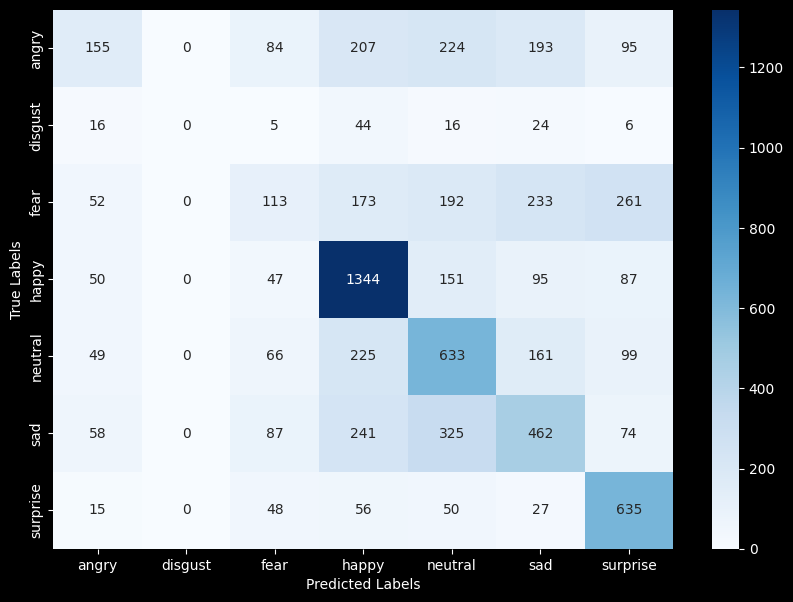

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_set.class_indices.keys(),
            yticklabels=test_set.class_indices.keys())
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [ ]:
import pandas as pd

filenames = test_set.filenames
predicted_labels = [list(test_set.class_indices.keys())[i] for i in y_pred]

df = pd.DataFrame({"image": filenames, "prediction": predicted_labels})
df.to_csv("predictions.csv", index=False)

df.head()


,image,prediction
0,angry/PrivateTest_10131363.jpg,happy
1,angry/PrivateTest_10304478.jpg,fear
2,angry/PrivateTest_1054527.jpg,sad
3,angry/PrivateTest_10590091.jpg,sad
4,angry/PrivateTest_1109992.jpg,fear


In [ ]:
model.save("emotion_model.keras")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving best_model.keras to best_model.keras
Saving predictions.csv to predictions.csv
Saving reviews_faiss.index to reviews_faiss.index
Saving reviews_metadata.csv to reviews_metadata.csv


In [ ]:
# installing required packages
!pip install -q sentence-transformers faiss-cpu transformers datasets nltk scikit-learn

# Optional (if you want LangChain integration later)
!pip install -q langchain


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 92.7 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import normalize
from transformers import pipeline

# small reproducibility
np.random.seed(42)


In [ ]:

pred_csv_path = "predictions.csv"
if os.path.exists(pred_csv_path):
    df = pd.read_csv(pred_csv_path)
else:

    df = pd.DataFrame({
        "image": ["img1.jpg", "img2.jpg", "img3.jpg"],
        "prediction": ["happy", "sad", "surprise"]
    })

df.head()


,image,prediction
0,angry/PrivateTest_10131363.jpg,happy
1,angry/PrivateTest_10304478.jpg,fear
2,angry/PrivateTest_1054527.jpg,sad
3,angry/PrivateTest_10590091.jpg,sad
4,angry/PrivateTest_1109992.jpg,fear


In [ ]:

templates = {
    "happy": [
        "I had a wonderful time — everything was great and cheerful.",
        "This made my day; I felt very happy and pleased."
    ],
    "sad": [
        "I felt disappointed and unhappy with the experience.",
        "This left me feeling down; it didn't meet my expectations."
    ],
    "angry": [
        "I was upset by this and found it frustrating.",
        "Very annoyed — this was unacceptable and angry-making."
    ],
    "surprise": [
        "I was pleasantly surprised and didn't expect such results!",
        "What a surprise — unexpectedly good and engaging."
    ],
    "fear": [
        "I felt uneasy and worried about how this behaved.",
        "This caused me concern and some anxiety."
    ],
    "neutral": [
        "It was okay — nothing special, but not bad either.",
        "A neutral experience overall; neither good nor bad."
    ],
    "disgust": [
        "I found this unpleasant and off-putting.",
        "This felt distasteful and I did not like it."
    ]
}

import random
random.seed(42)

rows = []
for i, r in df.iterrows():
    emotion = r['prediction']
    if emotion not in templates:
        emotion = "neutral"
    text = random.choice(templates[emotion])
    rows.append({
        "image": r['image'],
        "emotion": r['prediction'],
        "generated_review": text
    })

reviews_df = pd.DataFrame(rows)
reviews_df.head(10)


,image,emotion,generated_review
0,angry/PrivateTest_10131363.jpg,happy,I had a wonderful time — everything was great ...
1,angry/PrivateTest_10304478.jpg,fear,I felt uneasy and worried about how this behaved.
2,angry/PrivateTest_1054527.jpg,sad,This left me feeling down; it didn't meet my e...
3,angry/PrivateTest_10590091.jpg,sad,I felt disappointed and unhappy with the exper...
4,angry/PrivateTest_1109992.jpg,fear,I felt uneasy and worried about how this behaved.
5,angry/PrivateTest_11296953.jpg,fear,I felt uneasy and worried about how this behaved.
6,angry/PrivateTest_12000629.jpg,neutral,"It was okay — nothing special, but not bad eit..."
7,angry/PrivateTest_12008383.jpg,angry,I was upset by this and found it frustrating.
8,angry/PrivateTest_12191716.jpg,happy,This made my day; I felt very happy and pleased.
9,angry/PrivateTest_1221822.jpg,angry,I was upset by this and found it frustrating.


In [ ]:
# load model
embed_model = SentenceTransformer('all-MiniLM-L6-v2')  # light and fast

texts = reviews_df['generated_review'].tolist()
embeddings = embed_model.encode(texts, show_progress_bar=True, convert_to_numpy=True)
# normalize for cosine
embeddings = normalize(embeddings, axis=1, norm='l2')
print("Embeddings shape:", embeddings.shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/225 [00:00<?, ?it/s]

Embeddings shape: (7178, 384)


In [ ]:
# build FAISS index
d = embeddings.shape[1]
index = faiss.IndexFlatIP(d)   # inner product
index.add(embeddings)          # add vectors

# Keep metadata in a DataFrame or list to map indices -> meta
metadata = reviews_df.to_dict(orient='records')

faiss.write_index(index, "reviews_faiss.index")
pd.DataFrame(metadata).to_csv("reviews_metadata.csv", index=False)

print("Saved FAISS index and metadata. N entries:", index.ntotal)


Saved FAISS index and metadata. N entries: 7178


In [ ]:
def retrieve(query, top_k=5):
    # embed query
    q_emb = embed_model.encode([query], convert_to_numpy=True)
    q_emb = normalize(q_emb, axis=1)
    # search
    D, I = index.search(q_emb, top_k)   # I: indices, D: similarity scores
    results = []
    for idx, score in zip(I[0], D[0]):
        meta = metadata[idx]
        results.append({
            "image": meta['image'],
            "emotion": meta['emotion'],
            "review": meta['generated_review'],
            "score": float(score)
        })
    return results

# quick test
print(retrieve("I want happy feedback about a product", top_k=3))


[{'image': 'angry/PrivateTest_19041965.jpg', 'emotion': 'surprise', 'review': "I was pleasantly surprised and didn't expect such results!", 'score': 0.48269888758659363}, {'image': 'angry/PrivateTest_1862370.jpg', 'emotion': 'surprise', 'review': "I was pleasantly surprised and didn't expect such results!", 'score': 0.48269888758659363}, {'image': 'angry/PrivateTest_1850005.jpg', 'emotion': 'surprise', 'review': "I was pleasantly surprised and didn't expect such results!", 'score': 0.48269888758659363}]


In [ ]:

# VADER:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def add_sentiment(hits):
    for h in hits:
        s = sia.polarity_scores(h['review'])
        h['sentiment'] = s  # includes compund, pos, neg, neu
    return hits

# Test
res = retrieve("some test query", top_k=3)
print(add_sentiment(res))


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


[{'image': 'angry/PrivateTest_19041965.jpg', 'emotion': 'surprise', 'review': "I was pleasantly surprised and didn't expect such results!", 'score': 0.16631704568862915, 'sentiment': {'neg': 0.0, 'neu': 0.531, 'pos': 0.469, 'compound': 0.6476}}, {'image': 'angry/PrivateTest_1862370.jpg', 'emotion': 'surprise', 'review': "I was pleasantly surprised and didn't expect such results!", 'score': 0.16631704568862915, 'sentiment': {'neg': 0.0, 'neu': 0.531, 'pos': 0.469, 'compound': 0.6476}}, {'image': 'angry/PrivateTest_1850005.jpg', 'emotion': 'surprise', 'review': "I was pleasantly surprised and didn't expect such results!", 'score': 0.16631704568862915, 'sentiment': {'neg': 0.0, 'neu': 0.531, 'pos': 0.469, 'compound': 0.6476}}]


In [ ]:
# Re-saving index and metadata already done. Example to reload:
index2 = faiss.read_index("reviews_faiss.index")
meta_df = pd.read_csv("reviews_metadata.csv")
metadata2 = meta_df.to_dict(orient='records')
print("Reloaded index with n entries:", index2.ntotal)


Reloaded index with n entries: 7178
